<img src="https://upload.wikimedia.org/wikipedia/en/a/a1/Visma_logo.jpg"
     align="right"
     width="30%"
     alt="Visma logo">

Semi supervised learning 
=============

<img src="http://www.rm.dk/siteassets/regional-udvikling/digitalisering/dabai/dabai-logo.png"
     align="right"
     width="20%"
     alt="DABAI logo">


The first set of methods cover the principals from the following summary: http://sci2s.ugr.es/ssl
A batch-generative method, consisting of Kmeans and Logistic Regression, is implemented to cover a naive approach. This experiment is compared to a baseline whice consists of only Logistic Regression. 



In [1]:
from pyspark.sql import functions as F
from pyspark.ml import clustering
from pyspark.ml import  feature
from pyspark.sql import DataFrame
from pyspark.sql import Window
from pyspark.ml import Pipeline
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style='whitegrid')

# Python imports
import sys
import os

# Adding workspace to the pythonpath
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from shared import Plot2DGraphs, create_dummy_data
from semisupervised import batch_generative_model

#####  Add some parameters in order to generate a dataset

In [2]:
mean_1 = [3.0, 3.0]
std_1 = [2, 2]
mean_2 = [-3.0, -3.0]
std_2 = [1. , 1.0]
n_1 = 300
n_2 = 300
n = [n_1, n_2]
mean = [mean_1, mean_2]
std = [std_1, std_2]

### An initial method to semi supervised learning

The following cells are ment to be a data creation method along with an initial try on generate model for semi supervised learning.


In [3]:
def compute_error_rate(data_frame, truth_label='real_label', found_label='prediction'):
    """
    
    """
    
    df_stats = (data_frame
                .groupBy([truth_label, found_label])
                .agg(F.count('prediction').alias('Prediction Count'))
               )
    n = (df_stats
         .select(F.sum(F.col('Prediction Count')).alias('n'))
         .collect()[0]['n']
        )
    wrong_guess = (df_stats
                   .filter((F.col(truth_label) != F.col(found_label)))
                   .select(F.sum(F.col('Prediction Count')).alias('errors'))
                   .collect()[0]['errors']
                  )
    df_stats.show()
    print(n)
    print(wrong_guess)
    print('Error-rate: {}'.format(wrong_guess/n))
    
    
    
    

###### Create the labled dataset, and with 1% used lables and the rest is set to NAN.

In [4]:
tester = create_dummy_data.create_labeled_data_with_clusters(n, mean, std, 0.01)
df_tester = spark.createDataFrame(tester)

The dataset with lables and available lables plotted

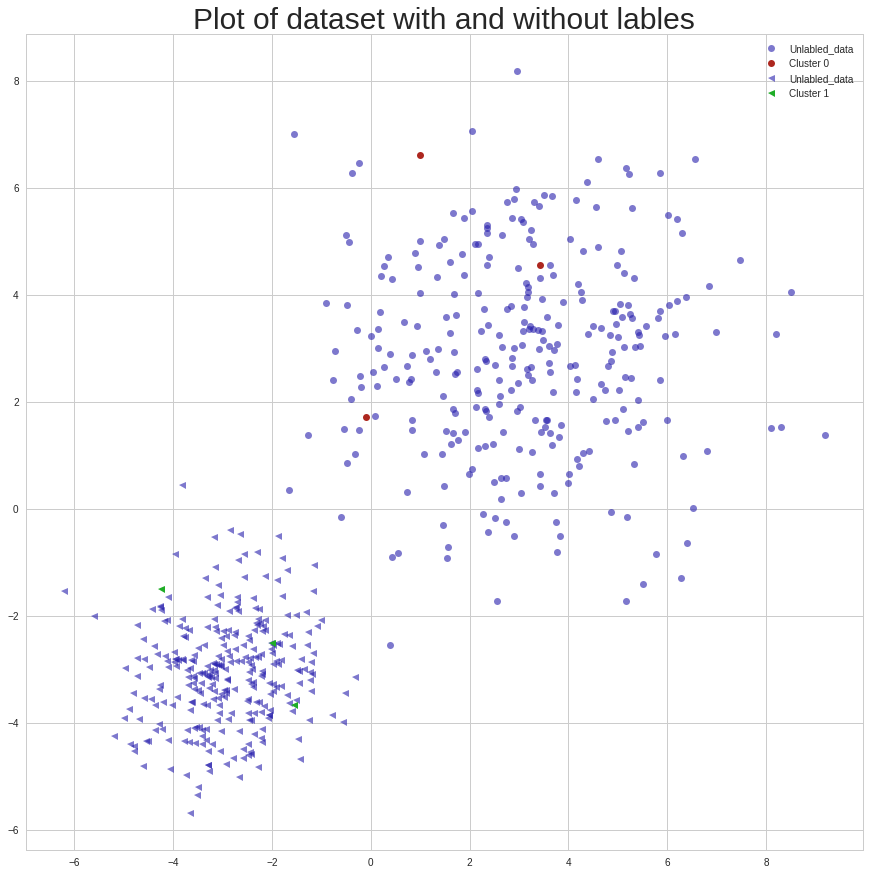

In [5]:
Plot2DGraphs.plot_known_and_unknown_data(tester)

###### The initial try at classifying the data, using logistic regression

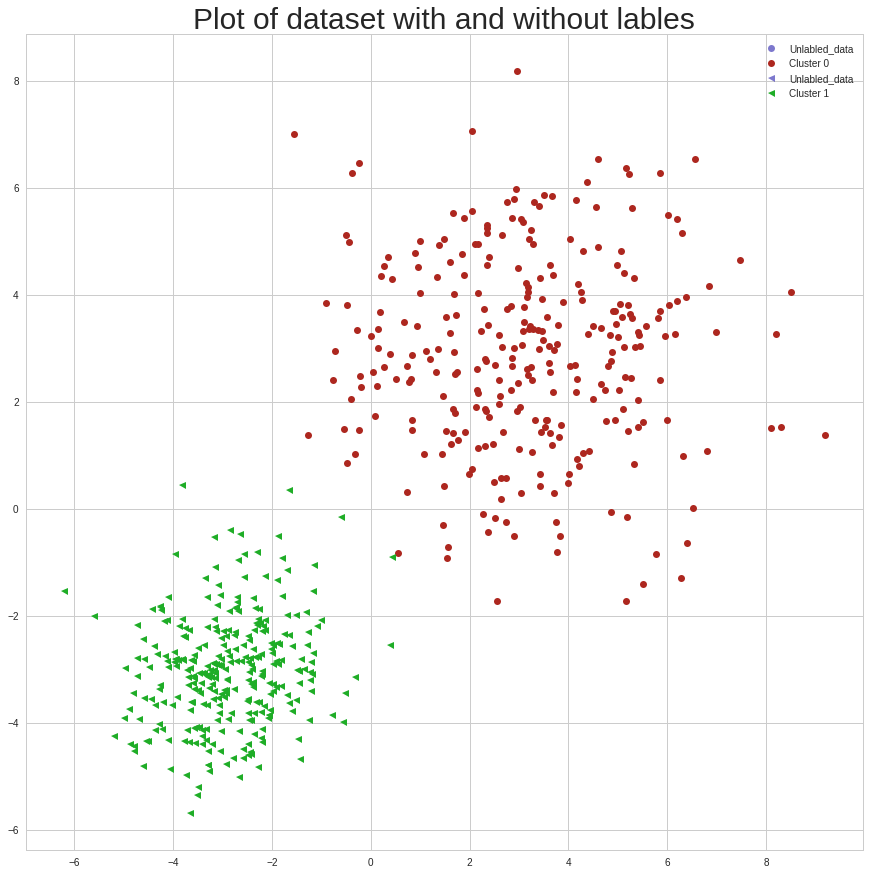

In [6]:
df_train = df_tester.filter((F.col('used_label') != np.NaN))
df_test = df_tester.filter((F.col('used_label') == np.NaN))

vec_assembler = feature.VectorAssembler(
    inputCols=['x','y'],
    outputCol='features')

lg = classification.LogisticRegression(
    featuresCol=vec_assembler.getOutputCol(),
    labelCol='used_label')

pipeline = Pipeline(stages=[vec_assembler, lg])
# CrossValidation gets build here!
param_grid = (ParamGridBuilder()
              .addGrid(lg.regParam, [0.1, 0.01])
              .build()
             )

evaluator = BinaryClassificationEvaluator(
    rawPredictionCol=lg.getRawPredictionCol(),
    labelCol=lg.getLabelCol())
    
cross_validator = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3)

cross_validator_model = cross_validator.fit(df_train)
df_without_semisupervised = cross_validator_model.transform(df_test)

Plot2DGraphs.plot_known_and_unknown_data(
    df_without_semisupervised.toPandas(),
    labelCol='prediction')



In [7]:
compute_error_rate(df_without_semisupervised)

+----------+----------+----------------+
|real_label|prediction|Prediction Count|
+----------+----------+----------------+
|       1.0|       1.0|             297|
|       0.0|       1.0|               4|
|       0.0|       0.0|             293|
+----------+----------+----------------+

594
4
Error-rate: 0.006734006734006734


##### Lets take a look at the semi supervised approach
This simplifyed version uses KMeans and Logistic Regression. In the future, the obvious thing to do is either create a user active system or use an ensembled approach

In [8]:
df_output = batch_generative_model.semi_supervised_batch_single_classifier_generate_approach(df_tester,['x','y'])

2


In [9]:
df_output.show(5)

+------------------+------------------+----------+----------+--------------------+-----------------+--------------------+--------------------+----------+
|                 x|                 y|real_label|used_label|            features|Kmeans_prediction|       rawPrediction|         probability|prediction|
+------------------+------------------+----------+----------+--------------------+-----------------+--------------------+--------------------+----------+
|2.3273593226046096|2.7498586834881356|       0.0|       NaN|[2.32735932260460...|                0|[1.62670961849264...|[0.83571839076942...|       0.0|
|3.7743747641947594|  3.06976019175855|       0.0|       NaN|[3.77437476419475...|                0|[2.18065236697199...|[0.89849858270798...|       0.0|
| 5.266449831557246|  2.44518304537472|       0.0|       NaN|[5.26644983155724...|                0|[2.44254422493307...|[0.92001451194997...|       0.0|
|1.9831200675456293|0.6420048729916386|       0.0|       NaN|[1.983120067545

+----------+----------+----------------+
|real_label|prediction|Prediction Count|
+----------+----------+----------------+
|       1.0|       1.0|             300|
|       0.0|       1.0|               5|
|       0.0|       0.0|             295|
+----------+----------+----------------+

600
5
Error-rate: 0.008333333333333333


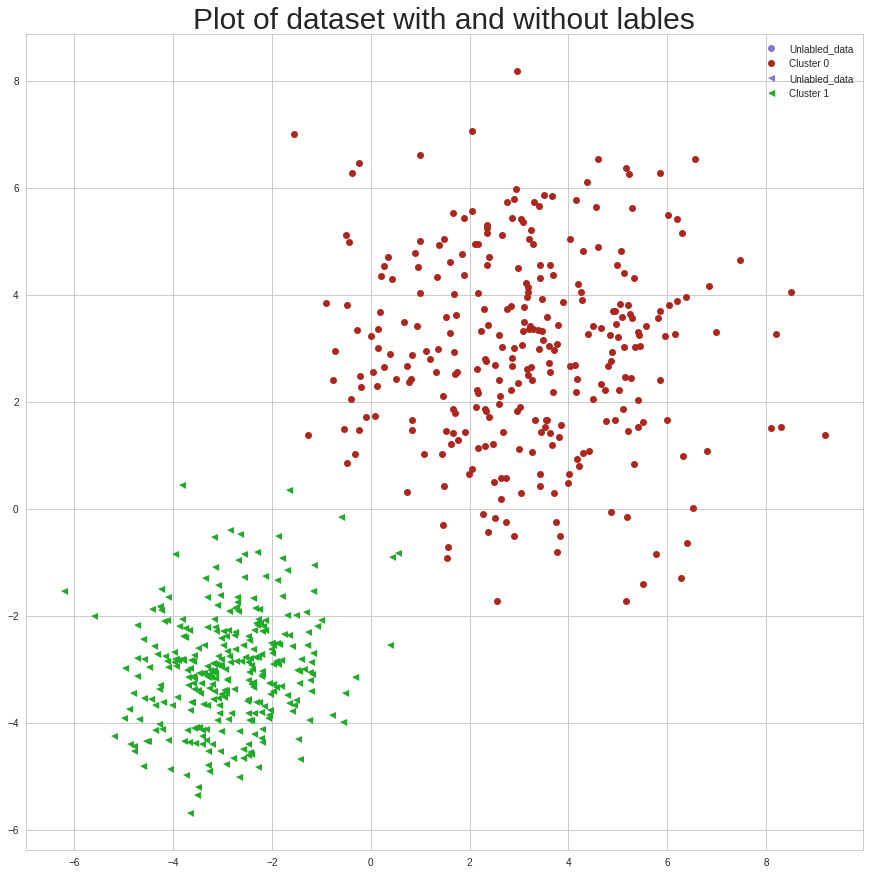

In [10]:
compute_error_rate(df_output)
Plot2DGraphs.plot_known_and_unknown_data(df_output.toPandas(), labelCol='prediction')